In [27]:
import formulaic
import pymc as pm
import pandas as pd

data = pd.read_csv("../../single_parameter/combined_data/statistics.csv")


# Dummy variables for Module and Parameters
model_formula = 'Coverage ~ 0 + C(TargetModule) + C(TuningParameters, contr.treatment("NONE"))'
design_matrix = formulaic.model_matrix(model_formula, data=data)

module_matrix = design_matrix.rhs.iloc[:, :24]
parameter_matrix = design_matrix.rhs.iloc[:, 24:]

# Dummy variables for interaction terms
model_formula = 'Coverage ~ 0 + C(TargetModule) : C(TuningParameters)'
design_matrix = formulaic.model_matrix(model_formula, data=data)

# Filter out columns that contain 'T.NONE' in their name
columns_to_drop = [col for col in design_matrix.rhs.columns if 'T.NONE' in col]

# Drop the identified columns
design_matrix.rhs.drop(columns=columns_to_drop, axis=1, inplace=True)
interaction_matrix = design_matrix.rhs.iloc[:,:]

# Create a matrix that maps interaction to parameter
p_matrix_copy = parameter_matrix.copy()
iteraction_matrix_copy = design_matrix.rhs.copy()
iteraction_to_parameter_matrix = iteraction_matrix_copy.T @ p_matrix_copy
iteraction_to_parameter_matrix = (iteraction_to_parameter_matrix > 0).astype(int)


In [28]:
with pm.Model() as model:
    # Global Intercept and standard deviation for Modules
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.0)
    sigma_a = pm.Exponential('sigma_a', 1.0)
    
    # Parameter specific intercept and global parameter standard deviation
    g_bar = pm.Normal('g_bar', mu=0, sigma = 0.5, shape= 12)
    sigma_g = pm.Exponential('sigma_g', 2)
    
    # Module-specific intercepts
    a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma_a, shape=24)

    # Interaction effects (with parameter specific intercept mean)
    g_mp = pm.Normal('g_mp', mu=pm.math.dot(iteraction_to_parameter_matrix, g_bar), sigma = sigma_g, shape=288)
                                
    # Activate the correct dummy variables
    logit_alpha = pm.math.dot(module_matrix, a_m)
    logit_gamma = pm.math.dot(interaction_matrix, g_mp)
    combined = logit_alpha + logit_gamma

    # Link function (logit), unbounded to (0,1) probability
    p = pm.Deterministic('p', pm.math.sigmoid(combined))
    
    # Beta distribution likelihood 
    theta = pm.Uniform('theta', 20, 200) # Disperion parameter
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=design_matrix.lhs['Coverage'])

    
    # Sample from the model
    trace = pm.sample(1000, chains=4, return_inferencedata=True, progressbar=True)
    log_lik = pm.compute_log_likelihood(trace)

print("Model building complete.")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma_a, g_bar, sigma_g, a_m, g_mp, theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1199 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Model building complete.


In [29]:
import arviz as az

az.to_netcdf(trace, "model_4_trace.nc")

'model_4_trace.nc'

In [30]:
az.loo(az.from_netcdf("model_4_trace.nc"))

Computed from 4000 posterior samples and 9360 observations log-likelihood matrix.

         Estimate       SE
elpd_loo 13384.20   235.56
p_loo      136.64        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     9358  100.0%
 (0.5, 0.7]   (ok)          2    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Sampling: [a_bar, a_m, g_bar, g_mp, sigma_a, sigma_g, theta]


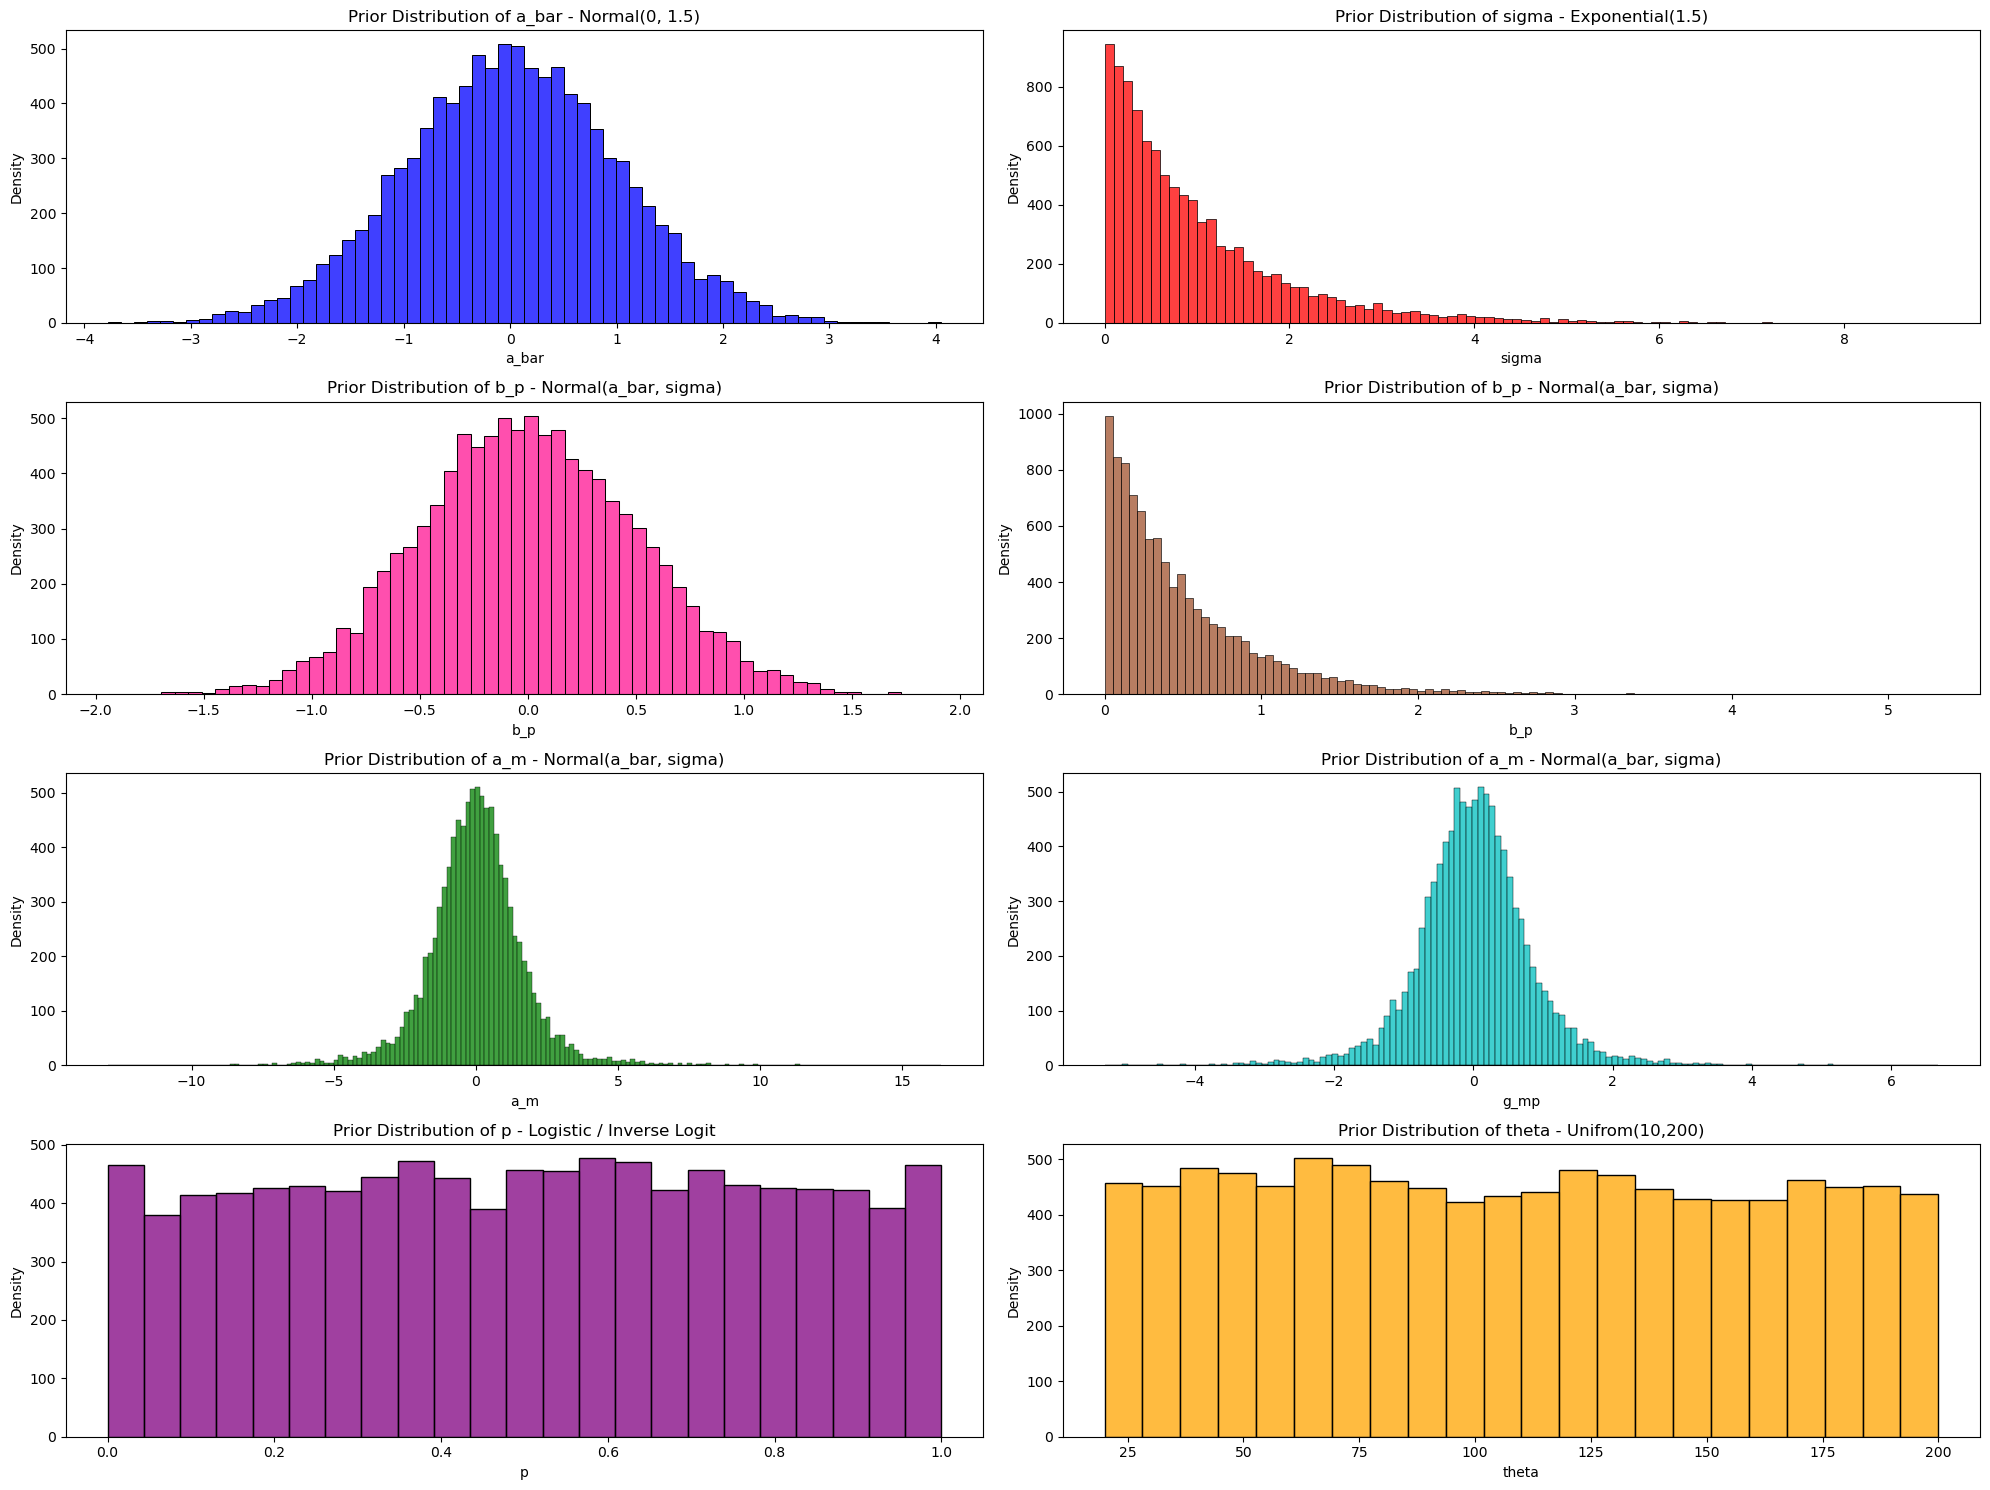

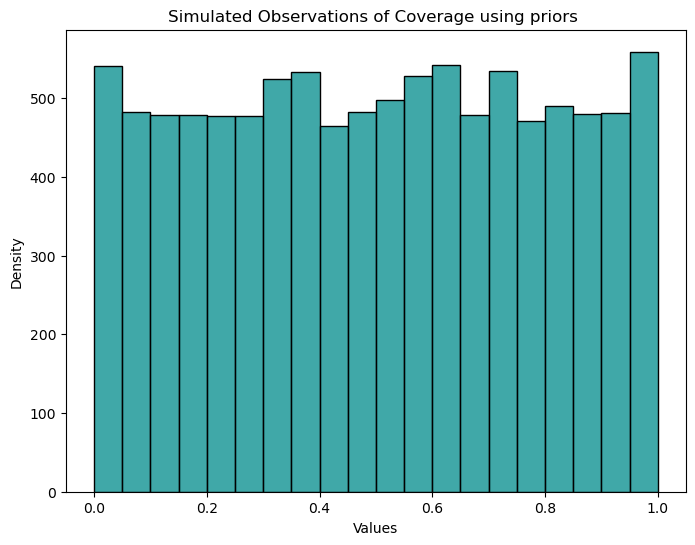

In [25]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

with pm.Model() as model:
    # Global Intercept and standard deviation for Modules
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.0)
    sigma_a = pm.Exponential('sigma_a', 1.0)
    
    # Parameter specific intercept and global parameter standard deviation
    g_bar = pm.Normal('g_bar', mu=0, sigma = 0.5)
    sigma_g = pm.Exponential('sigma_g', 2)
    
    # Module-specific intercepts
    a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma_a)

    # Interaction effects (with parameter specific intercept mean)
    g_mp = pm.Normal('g_mp', mu=g_bar, sigma = sigma_g)
                            
    
    # Link function (logit), unbounded to (0,1) probability
    combined = a_m + g_mp
    p = pm.Deterministic('p', pm.math.sigmoid(combined))
    
    # Beta distribution likelihood 
    theta = pm.Uniform('theta', 20, 200) # Disperion parameter
    
    # Sample Priors
    idata = pm.sample_prior_predictive(samples=10000)

# Fetch and flatten priors
prior_a_bar = idata.prior['a_bar'].values.flatten()
prior_sigma_a = idata.prior['sigma_a'].values.flatten()
prior_g_bar = idata.prior['g_bar'].values.flatten()
prior_sigma_g = idata.prior['sigma_g'].values.flatten()
prior_a_m = idata.prior['a_m'].values.flatten()
prior_g_mp = idata.prior['g_mp'].values.flatten()
prior_p = idata.prior['p'].values.flatten()
prior_theta = idata.prior['theta'].values.flatten()

# Sample one data point from each combination of priors
simulated_observations = np.random.beta(a=prior_p * prior_theta, b=(1 - prior_p) * prior_theta)


plt.figure(figsize=(20, 15))


# a_bar
plt.subplot(4, 2, 1)
sns.histplot(prior_a_bar, color='blue')
plt.title('Prior Distribution of a_bar - Normal(0, 1.5)')
plt.xlabel('a_bar')
plt.ylabel('Density')

# sigma
plt.subplot(4, 2, 2)
sns.histplot(prior_sigma_a, color='red')
plt.title('Prior Distribution of sigma - Exponential(1.5)')
plt.xlabel('sigma')
plt.ylabel('Density')

# g_bar
plt.subplot(4, 2, 3)
sns.histplot(prior_g_bar, color='deeppink')
plt.title('Prior Distribution of b_p - Normal(a_bar, sigma)')
plt.xlabel('b_p')
plt.ylabel('Density')

# sigma_g
plt.subplot(4, 2, 4)
sns.histplot(prior_sigma_g, color='sienna')
plt.title('Prior Distribution of b_p - Normal(a_bar, sigma)')
plt.xlabel('b_p')
plt.ylabel('Density')

# a_m
plt.subplot(4, 2, 5)
sns.histplot(prior_a_m, color='green')
plt.title('Prior Distribution of a_m - Normal(a_bar, sigma)')
plt.xlabel('a_m')
plt.ylabel('Density')

# g_mp
plt.subplot(4, 2, 6)
sns.histplot(prior_g_mp, color='c')
plt.title('Prior Distribution of a_m - Normal(a_bar, sigma)')
plt.xlabel('g_mp')
plt.ylabel('Density')

# p
plt.subplot(4, 2, 7)
sns.histplot(prior_p, color='purple')
plt.title('Prior Distribution of p - Logistic / Inverse Logit')
plt.xlabel('p')
plt.ylabel('Density')

# theta
plt.subplot(4, 2, 8)
sns.histplot(prior_theta, color='orange')
plt.title('Prior Distribution of theta - Unifrom(10,200)')
plt.xlabel('theta')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Predicated observations
plt.figure(figsize=(8, 6))
sns.histplot(simulated_observations, bins=np.arange(0, 1.05, 0.05), color='darkcyan')
plt.title('Simulated Observations of Coverage using priors ')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()
